This ipython notebook contains the code to scrape historical weather data for Eugene, OR. It could be easily modified to collect weather data for a different location. Base target site: www.wunderground.com 

First, the external packages used in this file:

In [1]:
import pandas as pd #for storing the scraped weather data in a local database
from urllib.request import urlopen #to download the html from the target website
from bs4 import BeautifulSoup #to navigate the downloaded html
import datetime #to do easy date math, setting the starting and ending dates
import numpy as np #for basic math purposes
import seaborn as sns #to create basic visualizations
import matplotlib.pyplot as plt #to create basic visualizations

This first block of code creates a list of days, from initDate through finDate, whose historical weather data will be scraped off of wunderground.com

In [2]:
initDate='11/19/2013';
finDate='1/8/2017';
initDateDT=datetime.datetime.strptime(initDate,'%m/%d/%Y')
finDateDT=datetime.datetime.strptime(finDate,'%m/%d/%Y')
periodDT=(finDateDT-initDateDT).days+1
datelist = pd.date_range(initDate, periods=periodDT, freq='D').strftime('%Y%m%d')
datelist = pd.date_range(initDate, periods=periodDT, freq='D')
uniqueDates=list(datelist);
print(min(uniqueDates))
print(max(uniqueDates))

2013-11-19 00:00:00
2017-01-08 00:00:00


Next, initialize a pandas dataframe to store the scraped data and set the categories of data to save.

In [3]:
df=pd.DataFrame()

In [4]:
categories=['Mean Temperature', 'Max Temperature', 'Min Temperature', 'Precipitation', 
 'Wind Speed','Max Wind Speed','Max Gust Speed','Events'];

This next section is the web scraper. For every chosen date, the program downloads the html of the corresponding website, finds the table of historical weather data, and stores that information in a row of the dataframe. The code here is ugly: nested for loops and if statements and whatnot. Improving this may come in the future. However, it does get the job done.

In [5]:
z=0;
for date in uniqueDates:
    year, month, day=date.strftime('%Y %m %d').split(' ')
    url='https://www.wunderground.com/history/airport/KEUG/%s/%s/%s/DailyHistory.html?req_city=Eugene&req_state=OR&req_statename=Oregon&reqdb.zip=97404&reqdb.magic=1&reqdb.wmo=99999' % (year, month, day)
    html = urlopen(url);
    bsObj = BeautifulSoup(html.read(), 'lxml');
    bsObj2=bsObj.find('table', class_='responsive airport-history-summary-table');
    bsObj2_list=bsObj2.find_all('td');
    x=0;
    subset=[];
    for term in categories:
        if term=='Events':
            subset3=[]
            for y in range(x,len(bsObj2_list)):
                if bsObj2_list[y].text==term:
                    subset3.append(term)
                    subset3.append(bsObj2_list[y+1].text.replace('\t','').replace('\n',''));
            subset.append(subset3)
        for y in range(x, len(bsObj2_list)):
            try:
                if bsObj2_list[y].text==term:
                    subset2=[];
                    subset2.append(term);
                    subset2.append(bsObj2_list[y+1].find(class_='wx-value').text)
                    try:
                        subset2.append(bsObj2_list[y+2].find(class_='wx-value').text)
                    except:
                        pass
                    try:
                        subset2.append(bsObj2_list[y+3].find(class_='wx-value').text)
                    except:
                        pass
                    subset.append(subset2)
            except:
                pass
    for term in subset:
        if len(term)>=3:
            subset.append([term[0]+' Average',term[2]])
        if len(term)>=4:
            subset.append([term[0]+' Record',term[3]])
    for term in subset:
        try:
            df.loc[z,term[0]]=term[1]
        except:
            pass
        df.loc[z,'Date']=date
    z=z+1

In [6]:
df.head()

,Mean Temperature,Date,Max Temperature,Min Temperature,Precipitation,Wind Speed,Max Wind Speed,Max Gust Speed,Events,Mean Temperature Average,Max Temperature Average,Max Temperature Record,Min Temperature Average,Min Temperature Record,Precipitation Average,Precipitation Record
0,49,2013-11-19,56,42,0.43,12,20,23,Rain,44,51,69,37,20,0.27,2.40
1,37,2013-11-20,44,30,0.00,13,24,29,,44,51,69,37,22,0.27,2.30
2,35,2013-11-21,45,24,0.00,10,21,24,,44,50,63,37,19,0.28,2.00
3,33,2013-11-22,46,19,0.00,4,16,20,,43,50,65,37,19,0.28,2.93
4,36,2013-11-23,49,22,0.00,4,15,18,,43,50,71,37,18,0.29,2.30


Now I can do a bit of cleaning before saving the dataframe as a csv file.

In [7]:
df.loc[df['Precipitation']=='T','Precipitation']=np.nan; #I don't know what 'T' stands for, but let's remove it.
Cols=df.columns;
for col in Cols:
    try:
        df[col]=df[col].astype(float) #making anything that can be a number, a number.
    except:
        pass
df['Date_Diff']=df['Date'].apply(lambda x: (x - df.loc[:,'Date'].min()).days) #convert for daysf since start
df.loc[:,'Events'].fillna('None',inplace=True) #Fill blanks
df.loc[:,'Events']=df.loc[:,'Events'].str.replace('\xa0','None'); #fill equivalent of blanks

And some basic visualizations of the data:

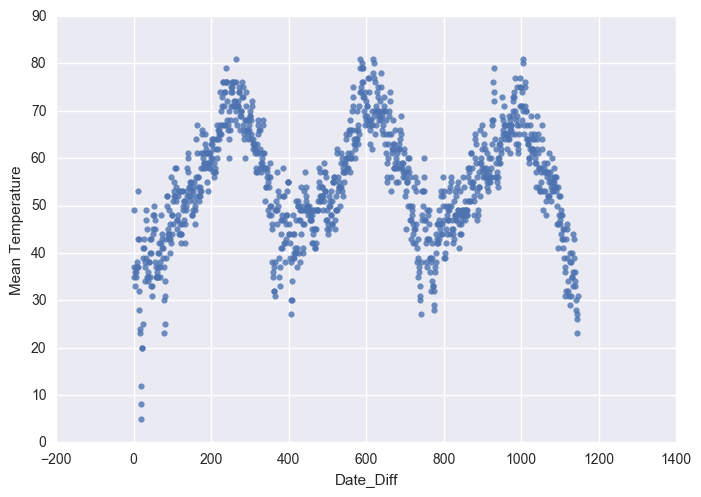

In [8]:
sns.regplot(x='Date_Diff',y='Mean Temperature',data=df, fit_reg=False)
plt.show()

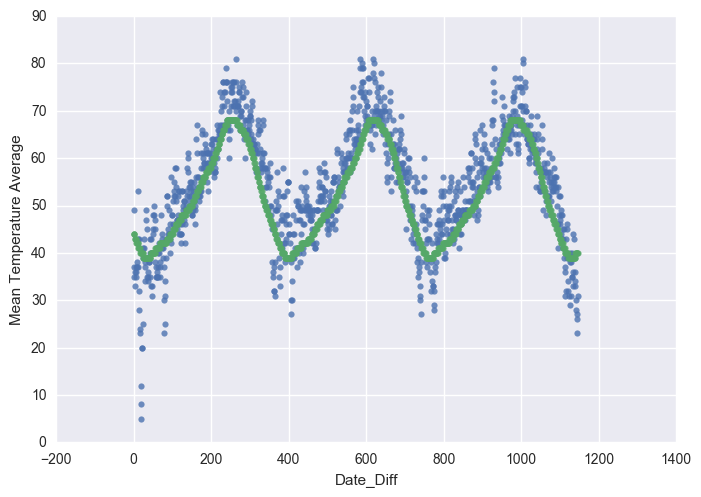

In [9]:
sns.regplot(x='Date_Diff',y='Mean Temperature',data=df, fit_reg=False)
sns.regplot(x='Date_Diff',y='Mean Temperature Average',data=df, fit_reg=False)
plt.show()

And finally, save to csv file:

In [10]:
df.to_csv('weather_data.csv',index=False)

In [2]:
(4000*60)/60/60

66.66666666666667